<font color='green'>**Alumno:**</font> Morón, Harold Matías.

<font color='green'>**Grupo:**</font> ds-online-43

<font color='green'>**Link del Proyecto en GitHub:**</font> https://github.com/hmatiasmoron/Proyecto3-ML-TimeSeries

# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

#Librerías agregadas
import seaborn as sns
sns.set()

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

#from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from fbprophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

import random

#import warnings
#warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [10]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [11]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [12]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [13]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


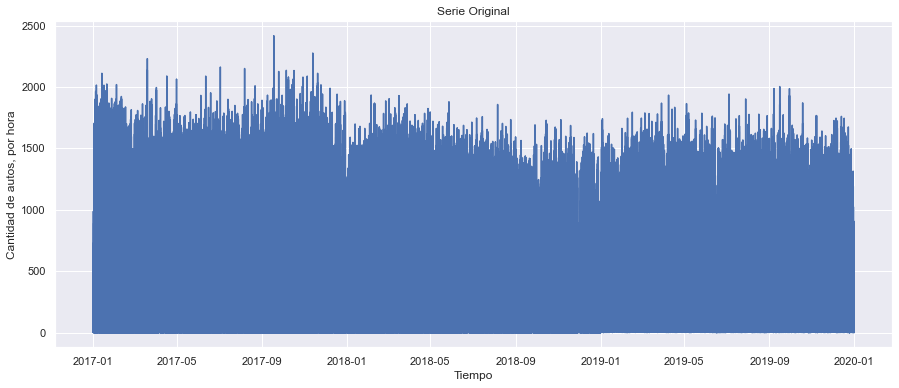

In [14]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.title('Serie Original')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [15]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


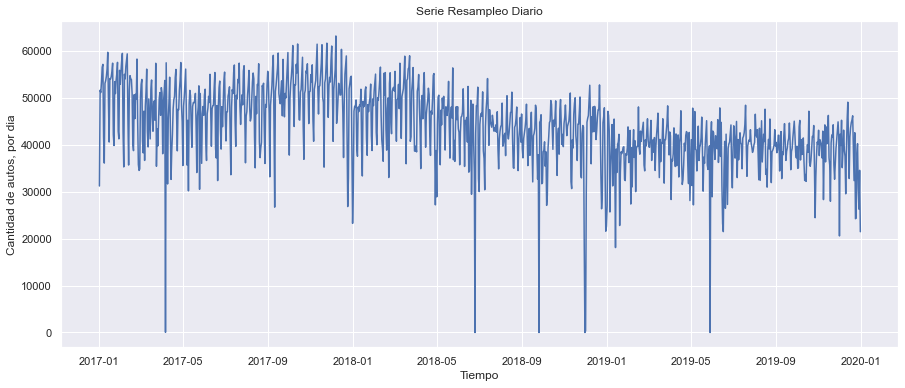

In [16]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.title('Serie Resampleo Diario')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [17]:
#Resampleamos nuestros datos para agrupar por semana, y asi tal vez lograr una visualización mas amigable
semanal = dataset.resample('W', on = 'fecha').sum()
print(semanal.shape)
semanal.head()

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581


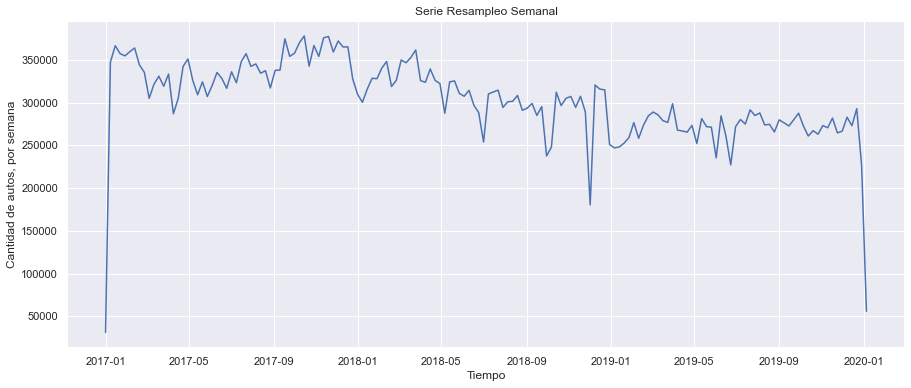

In [18]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.title('Serie Resampleo Semanal')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

# Componentes de la Serie

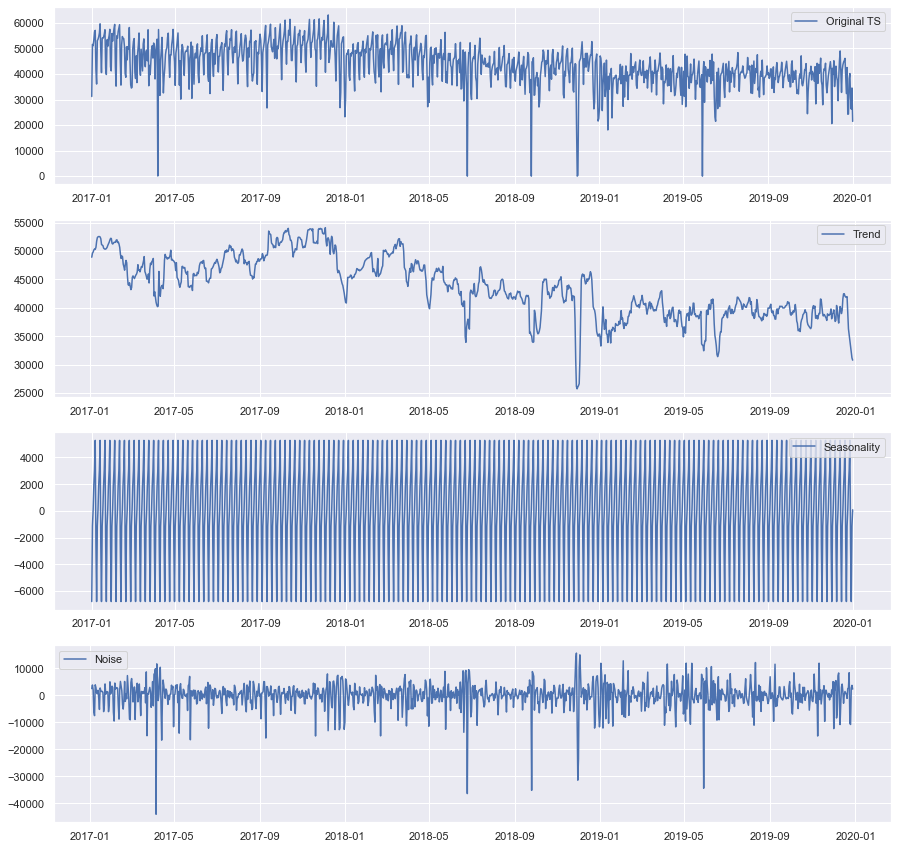

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(diario['cantidad_pasos'], model='aditive')

trend = decomposition.trend
seasonal = decomposition.seasonal
noise = decomposition.resid
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(diario, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(noise, label='Noise')
plt.legend(loc='best')
plt.show()

* <font color='green'>**Frecuencia**</font>: Podemos determinar que la frecuencia de muestreo de la serie es horaria, ya que se registra la cantidad de pasos por tipo de vehículo por cada hora del día.

* <font color='green'>**Tendencia**</font>: Podemos determinar que la tendencia de la serie es negativa, por el segundo gráfico (Trend).

* <font color='green'>**Estacionalidad**</font>: No es posible determinar la misma con el resampleo a frecuencia diaria.  

## Se realiza el decompose con el resampleo de la serie a semanal

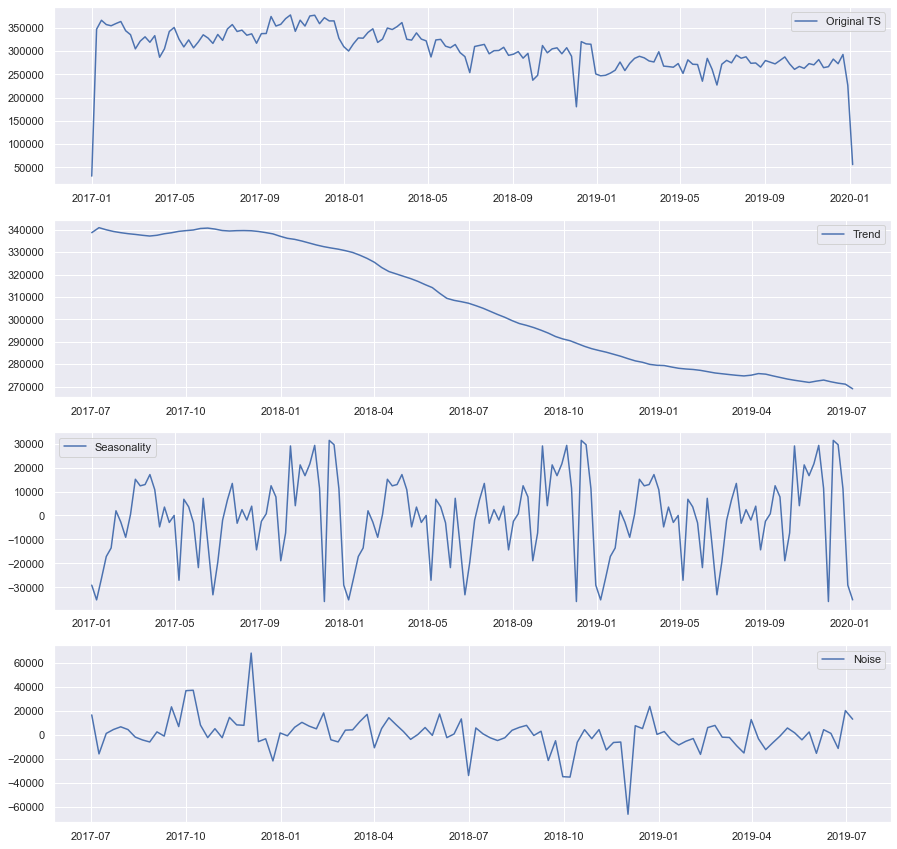

In [20]:
decomposition_s = seasonal_decompose(semanal['cantidad_pasos'], model='aditive')

trend_s = decomposition_s.trend
seasonal_s = decomposition_s.seasonal
noise_s = decomposition_s.resid
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(semanal, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_s, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_s,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(noise_s, label='Noise')
plt.legend(loc='best')
plt.show()

* <font color='green'>**Estacionalidad**</font>: Al resamplear la muestra de la serie de tiempo a semanal, es posible determinar que la estacionalidad de la serie es anual.

# Análisis Exploratorio de Datos (EDA)

Cantidad de Pasos agrupados por Día 

         dia  cantidad_pasos
0    Viernes         7647272
1     Jueves         7302169
2  Miércoles         7125526
3     Martes         6865551
4      Lunes         6691387
5     Sábado         6441715
6    Domingo         5791961


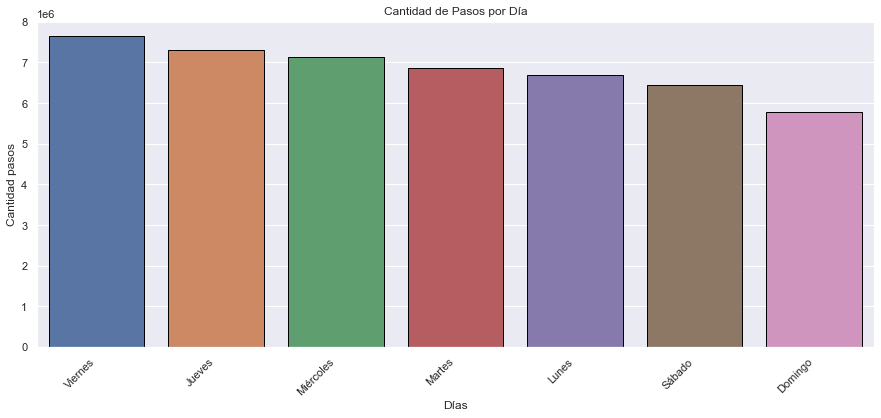

In [21]:
#Otra manera de traer totalizado por Día la cantidad de pasos
print("Cantidad de Pasos agrupados por Día","\n")
#print(dataset.groupby(['dia'])['cantidad_pasos'].sum().reset_index())

datos_por_dia = dataset.groupby(['dia'])['cantidad_pasos'].sum().reset_index()
#pd_df = pd_df.sort_values(['Count']).reset_index(drop=True)

datos_por_dia = datos_por_dia.sort_values(['cantidad_pasos'],ascending=False).reset_index(drop=True)
print(datos_por_dia)

#plt.figure(figsize = (15,8))
plt.figure(figsize = (15,6))
#sns.barplot(data = dataset, x = "dia",y= 'cantidad_pasos')
sns.barplot(data = datos_por_dia, x = "dia",y= 'cantidad_pasos',linewidth=1,edgecolor=(0,0,0))#,order=datos_por_dia["cantidad_pasos"].value_counts().index)


plt.title("Cantidad de Pasos por Día")
plt.xticks(rotation=45,ha='right')
plt.xlabel("Días")
plt.ylabel("Cantidad pasos")
#plt.tight_layout()
plt.show()

In [22]:
#Otra manera para graficar la cantidad de pasos agrupados por día
#dataset.groupby("dia")['cantidad_pasos'].sum().plot(kind='bar')

Cantidad de Pasos agrupados por Hora 

    hora  cantidad_pasos
0     18         3115036
1     19         3071455
2     14         3005578
3     17         2993721
4     16         2969568
5     15         2933388
6     13         2907990
7     12         2729369
8     20         2661885
9     11         2551110
10     9         2476701
11    10         2471790
12    21         2339949
13     8         2276977
14    22         1875810
15     7         1564013
16    23         1412685
17     0         1057141
18     1          879116
19     6          781617
20     2          614594
21     3          429898
22     5          411330
23     4          334860


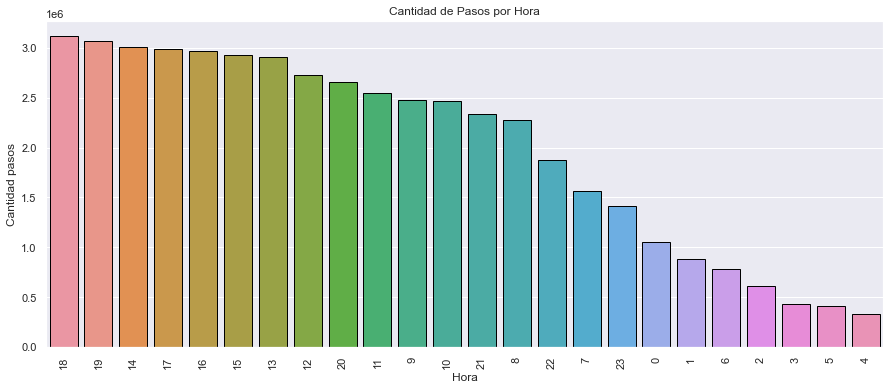

In [23]:
datos_por_hora = dataset.copy()
datos_por_hora["hora"] = datos_por_hora["fecha"].dt.hour

print("Cantidad de Pasos agrupados por Hora","\n")

datos_por_hora_view = datos_por_hora.groupby(['hora'])['cantidad_pasos'].sum().reset_index()
##pd_df = pd_df.sort_values(['Count']).reset_index(drop=True)

datos_por_hora_view = datos_por_hora_view.sort_values(['cantidad_pasos'],ascending=False).reset_index(drop=True)
print(datos_por_hora_view)

#plt.figure(figsize = (15,8))
plt.figure(figsize = (15,6))
#sns.barplot(data = dataset, x = "dia",y= 'cantidad_pasos')
sns.barplot(data = datos_por_hora_view, x = "hora",y= 'cantidad_pasos',linewidth=1,edgecolor=(0,0,0),order=datos_por_hora_view["hora"])#,order=datos_por_hora_view["cantidad_pasos"].value_counts().index)


plt.title("Cantidad de Pasos por Hora")
plt.xticks(rotation=90,ha='center')
plt.xlabel("Hora")
plt.ylabel("Cantidad pasos")
plt.show()

In [24]:
print("Filas y columnas del Data Resampleado a Diario:",diario.shape,"\n")

print("Primeras 5 filas (instancias): \n")
diario.head()

Filas y columnas del Data Resampleado a Diario: (1095, 1) 

Primeras 5 filas (instancias): 



,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [25]:
print("Tipos de Datos Columnas del Data Set Resampleado a Diario: \n")
diario.info()
#print("\n")
#print("Datos Faltantes en las columnas (features): \n")
#dataset.isnull().sum()

Tipos de Datos Columnas del Data Set Resampleado a Diario: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   cantidad_pasos  1095 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB


In [26]:
print("Diferentes cálculos para el estudio de las variables (features):")
print("Sólo se realiza para el feature cantidad_pasos, ya que este solamente es cuantitativo, los demás son features cualitativos (categóricos) y además fueron eliminados en el resampleo diario:")
#dataset.describe()
diario.describe()

Diferentes cálculos para el estudio de las variables (features):
Sólo se realiza para el feature cantidad_pasos, ya que este solamente es cuantitativo, los demás son features cualitativos (categóricos) y además fueron eliminados en el resampleo diario:


,cantidad_pasos
count,1095.000000
mean,43712.859361
std,8192.736927
min,0.000000
25%,39061.500000
50%,43761.000000
75%,49498.000000
max,63127.000000


## Outliers

### Para quitar valores atípicos (Outliers) pensé en una primera instacia utilizar el Método de Desviación Estándar, aplicando 3 Desviaciones Estandar de la media, de esta manera nos aseguramos de tomar el 99,7 % de los datos. En caso que el intervalo <font color='green'>DESDE</font> donde filtraremos sea negativo, se tomará un valor razonable para este en base a un estudio del tipo de feature y valores que toma.
### Pero termine optando por utilizar en este caso de predicción en Series de Tiempo Interpolación, ya que se considera mas adecuado que complete estos valores, evitando así que la serie de tiempo tenga "cortes" en sus valores a predecir, pues cuando se deben realizar cortes de manera transversal para eliminar outliers es mas conveniente el primer metodo mencionado y para cortes horizontales este ultimo al cual se hace mención

In [27]:
dataset_msk = ((diario["cantidad_pasos"]<15000))
dataset_otlrs = diario[dataset_msk]
dataset_otlrs

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


In [28]:
#Completo con NaN los valores a Interpolar
diario.cantidad_pasos[diario.cantidad_pasos <=15000] = np.nan

In [29]:
#Sumo la cantidad de casos con valor NaN
print(diario.isna().sum())
#Realizo la interpolación
diario = diario.interpolate(method='nearest', k=4)
#Verifico que no queden valores NaN
print(diario.isna().sum())

cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


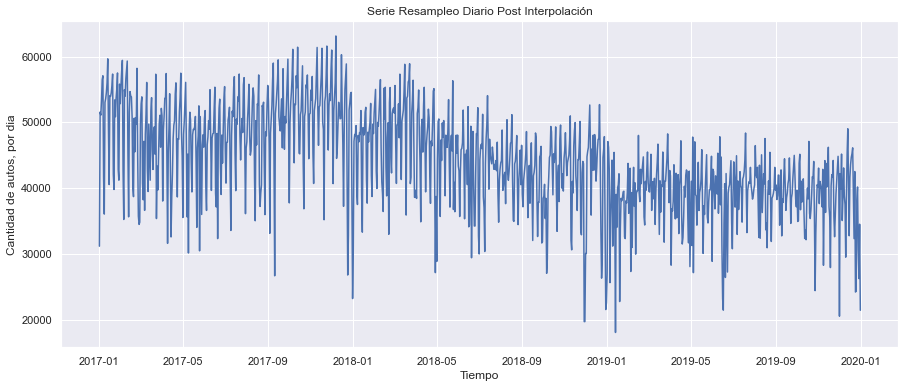

In [30]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.title('Serie Resampleo Diario Post Interpolación')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

### Respecto a estos valores atípicos en la cantidad de pases, realizando una búsqueda en Google pudimos dar con la siguiente información:

* **2017-04-06**
#### HUELGA GENERAL EN ARGENTINA
Fuertes choques entre la policía y los huelguistas en el primer gran paro contra Macri
Las dos principales centrales obreras y organizaciones sociales llaman a paralizar el país en contra de la política económica. **Fuente:** https://elpais.com/internacional/2017/04/06/argentina/1491441490_387006.html

* **2018-06-25**
#### Los sindicatos peronistas paralizan por tercera vez Argentina
La CGT se une contra la política económica de Mauricio Macri y el acuerdo con el Fondo Monetario. **Fuente:** https://elpais.com/internacional/2018/06/25/argentina/1529921664_282510.html

* **2018-09-25**
#### PROTESTAS EN ARGENTINA
Argentina: protestas contra Macri a horas de la huelga general. **Fuente:** https://www.france24.com/es/20180925-argentina-protestas-macri-huelga-general

* **2018-11-30 y 2018-12-01**
#### Cumbre del G-20 en Buenos Aires (Argentina), 30 de noviembre y 1 de diciembre de 2018.
 **Fuente:** https://www.consilium.europa.eu/es/meetings/international-summit/2018/11/30-01/
 
* **2019-05-29**
#### La mayor huelga general contra Mauricio Macri paraliza Argentina
El quinto paro desde 2015 fortalece el cerco opositor contra el presidente en el inicio de la campaña electoral. **Fuente:** https://elpais.com/internacional/2019/05/29/argentina/1559153842_024679.html

## Imputación de valores faltantes

In [31]:
print("Datos Faltantes en las columnas (features): \n")
#dataset.isnull().sum()
diario.isnull().sum()

Datos Faltantes en las columnas (features): 



cantidad_pasos    0
dtype: int64

### Como podemos observar no tenemos valores faltantes en los features, por lo que no se llevará a cabo ninguna acción.

## Correlaciones

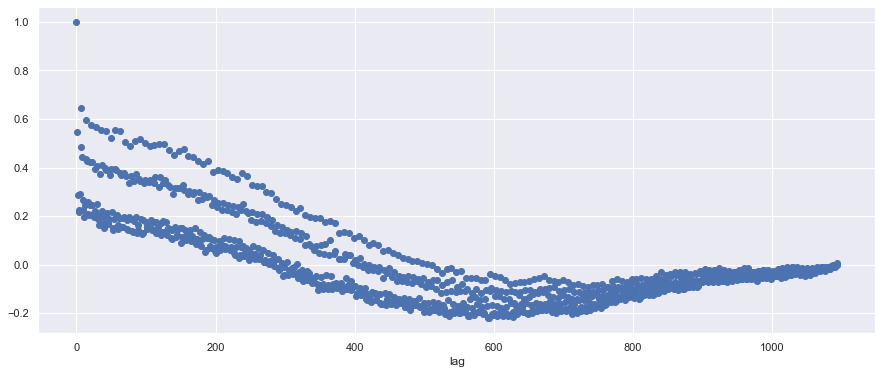

In [32]:
nlags =  (365*3)#52*3#
autocorr = acf(diario.cantidad_pasos, nlags = nlags,fft=False)

plt.figure(figsize = (15,6))
plt.scatter(np.arange(nlags), autocorr)#(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.show()

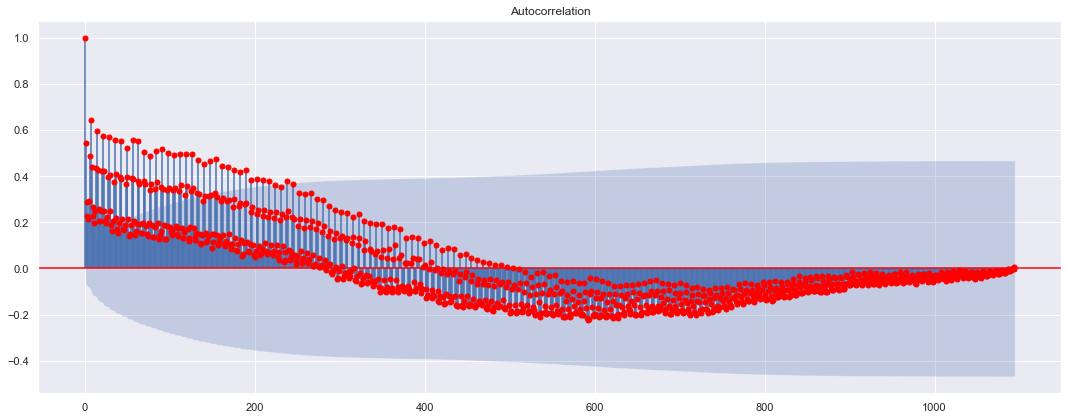

In [33]:
#plt.figure(figsize = (15,6))
plt.rc("figure", figsize=(15,6))
plot_acf(diario.cantidad_pasos, lags = nlags-1, color='red')
#plot_acf(diario.cantidad_pasos, color='red')
plt.tight_layout()
plt.show()

## Encoding

### No se realizará encoding de features, ya que al trabajar con el dataset original resampleado a diario, perdemos los features que no pueden ser unificados bajo un mismo criterio, como por ejemplo suma, promedio, etc.

### Modelo Benchmark

In [34]:
senial = diario.cantidad_pasos
senial

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
               ...   
2019-12-27    40182.0
2019-12-28    30681.0
2019-12-29    26259.0
2019-12-30    34523.0
2019-12-31    21447.0
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

In [35]:
senial.head(8)

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
2017-01-06    57081.0
2017-01-07    41587.0
2017-01-08    36065.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [36]:
senial.shape

(1095,)

In [37]:
look_back = 7 # usamos una semana de datos para predecir el valor siguiente

In [38]:
N = senial.shape[0]
#Original
#X = np.zeros((N - look_back - 1,look_back))
#y = np.zeros(N - look_back - 1)
#Primer Modificación
X = np.zeros((N - look_back,look_back))#((N - look_back - 1,look_back))
y = np.zeros(N - look_back)#(N - look_back - 1)
#Segunda modificación
#X = np.zeros((N,look_back))
#y = np.zeros(N)
print(X.shape, y.shape)

(1088, 7) (1088,)


In [39]:
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [40]:
#N_train = 365*2 - look_back # cantidad de instancias que vamos a usar para entrenar. 
#N_test = 365*1 #cantidad de puntos que vamos a usar para evaluar
N_train = 1003 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 92 #cantidad de puntos que vamos a usar para evaluar

N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

#ANTES
#(996, 7) (996,)
#(91, 7) (91,)

(996, 7) (996,)
(92, 7) (92,)


In [41]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

In [42]:
#lr = LinearRegression()
#lr.fit(X_train,y_train)

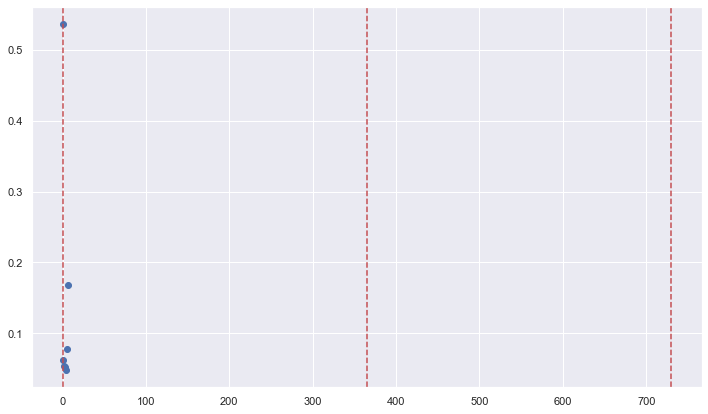

In [43]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
for x in np.arange(3)*365:
     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

#### Podemos decir que el día previo, es el feature más relevante en la predicción.

In [44]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [45]:
#y_pred = lr.predict(X)
#y_train_pred = lr.predict(X_train)
#y_test_pred = lr.predict(X_test)

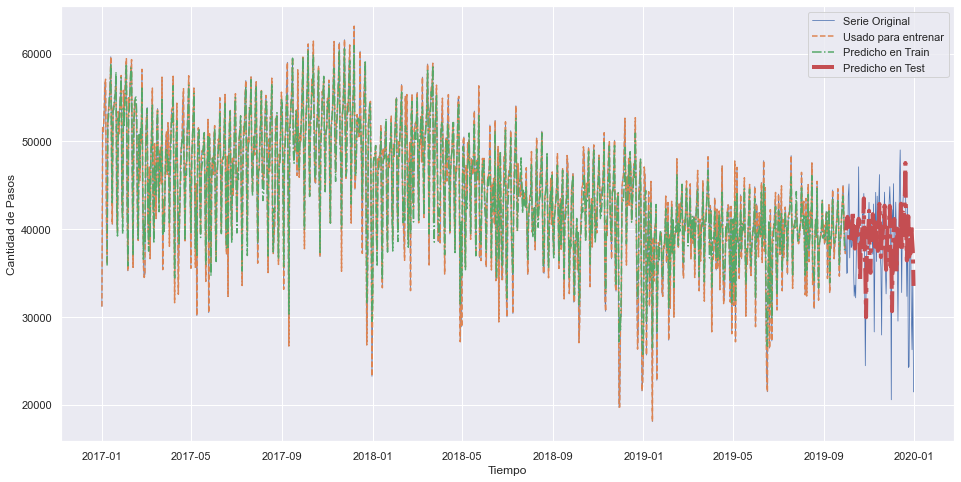

In [46]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [47]:
rmse_prevision_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Raíz del error cuadrático medio en Train Modelo Benchmark: {round(rmse_prevision_train,2)}')

rmse_prevision_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Test Modelo Benchmark: {round(rmse_prevision_test,2)}')

#Con 7 días como look back
#Raíz del error cuadrático medio en Train Modelo Benchmark: 1853.155522210622
#Raíz del error cuadrático medio en Test Modelo Benchmark: 5410.660649047536

#Antes de ultima modificación:
#Raíz del error cuadrático medio en Train Modelo Benchmark: 1856.1097730276533
#Raíz del error cuadrático medio en Test Modelo Benchmark: 5209.8665371093775

#Antes de ultima modificación RFR:
#Raíz del error cuadrático medio en Train Modelo Benchmark: 1869.84
#Raíz del error cuadrático medio en Test Modelo Benchmark: 5416.7

#Puntuación Linear Regression
#Raíz del error cuadrático medio en Train Modelo Benchmark: 5169.97
#Raíz del error cuadrático medio en Test Modelo Benchmark: 5759.43

Raíz del error cuadrático medio en Train Modelo Benchmark: 1869.84
Raíz del error cuadrático medio en Test Modelo Benchmark: 5416.7


### Modelo a trabajar - Prophet

#### Datos separacion en X e y, Train y Test

In [48]:
DS_prophet = pd.DataFrame()

DS_prophet["ds"] = pd.to_datetime(diario.index)
DS_prophet["y"] = diario['cantidad_pasos'].values

In [49]:
end_date = '2019-09-30'
mask1 = (DS_prophet['ds'] <= end_date)
mask2 = (DS_prophet['ds'] > end_date)

In [50]:
X_train = DS_prophet.loc[mask1]
X_test = DS_prophet.loc[mask2]
print("train shape",X_train.shape)
print("test shape",X_test.shape)

train shape (1003, 2)
test shape (92, 2)


In [51]:
DS_prophet

,ds,y
0,2017-01-01,31183.0
1,2017-01-02,51568.0
2,2017-01-03,51093.0
3,2017-01-04,53332.0
4,2017-01-05,56486.0
...,...,...
1090,2019-12-27,40182.0
1091,2019-12-28,30681.0
1092,2019-12-29,26259.0
1093,2019-12-30,34523.0


In [52]:
prophet_benchmark = Prophet()
prophet_benchmark.fit(X_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [53]:
#Como predecimos el ultimo trimestre, establecemos como 92 días el período.
future = prophet_benchmark.make_future_dataframe(periods=92)

In [54]:
future.head()

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05


In [55]:
future.tail()

,ds
1090,2019-12-27
1091,2019-12-28
1092,2019-12-29
1093,2019-12-30
1094,2019-12-31


In [56]:
future.shape

(1095, 1)

In [57]:
forecast = prophet_benchmark.predict(future)

In [58]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-01,39035.106375,33006.013910,45209.028689
1,2017-01-02,45071.389407,39179.836139,51291.690937
2,2017-01-03,46288.535647,39851.503449,52293.220469
3,2017-01-04,48112.230709,41972.506210,54039.054734
4,2017-01-05,49284.940297,43788.316707,55074.702888


In [59]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1090,2019-12-27,43587.759666,37698.010486,49213.877429
1091,2019-12-28,35347.335542,28998.432641,40820.440901
1092,2019-12-29,30460.282060,24009.166895,36062.462657
1093,2019-12-30,36371.628693,29850.377329,42494.465197
1094,2019-12-31,37458.181698,31345.941408,43765.283497


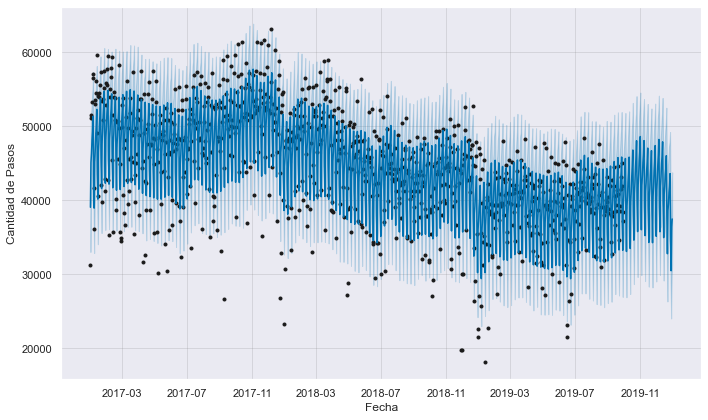

In [60]:
fig1 = prophet_benchmark.plot(forecast,xlabel='Fecha',ylabel='Cantidad de Pasos')

In [61]:
#Sumo al dataset el valor predicho
DS_prophet['yhat'] = forecast['yhat']

In [62]:
DS_prophet

,ds,y,yhat
0,2017-01-01,31183.0,39035.106375
1,2017-01-02,51568.0,45071.389407
2,2017-01-03,51093.0,46288.535647
3,2017-01-04,53332.0,48112.230709
4,2017-01-05,56486.0,49284.940297
...,...,...,...
1090,2019-12-27,40182.0,43587.759666
1091,2019-12-28,30681.0,35347.335542
1092,2019-12-29,26259.0,30460.282060
1093,2019-12-30,34523.0,36371.628693


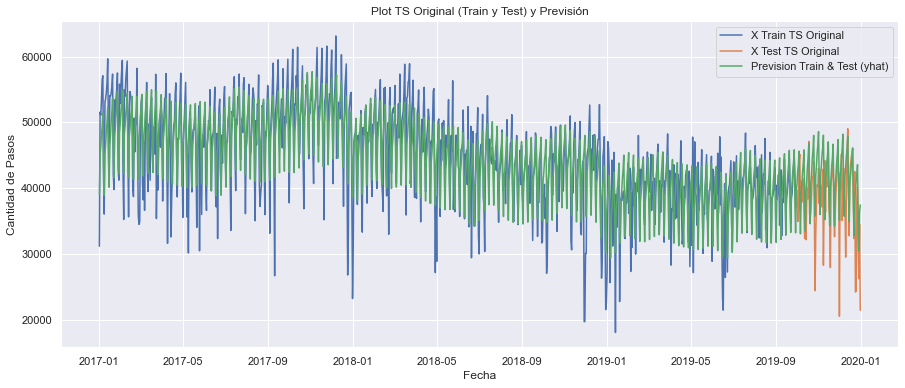

In [63]:
#Plot de Train y Test
plt.figure(figsize = (15,6))

#TS Original
#plt.plot(DS_prophet['ds'], DS_prophet['y'])#,label='y_real')
#X_train TS Original
plt.plot(X_train['ds'], X_train['y'])#,label='Y_predicted')
#X_test TS Original
plt.plot(X_test['ds'], X_test['y'])#,label='Y_predicted')

#TS Predicted
plt.plot(DS_prophet['ds'], DS_prophet['yhat'])#,label='Y_predicted')
#plt.legend(['y predicted'])

#forecast
#plt.plot(DS_prophet_test['ds'], DS_prophet_test['y'])#,label='Y_predicted')

plt.title('Plot TS Original (Train y Test) y Previsión')
#plt.legend(['y train','y train predicted ','y test','y test predicted'])
plt.legend(['X Train TS Original','X Test TS Original ','Prevision Train & Test (yhat)'])
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [64]:
##Con este join uno los data set para analizar como aprendió el modelo
#DS_rmse = pd.merge(forecast,DS_prophet,on="ds")
#DS_rmse

In [65]:
#Con este otro join tambien uno los data set para analizar como aprendió el modelo
#prevision = pd.merge(DS_prophet, forecast,
#                        how="inner", on="ds")
#prevision.head()
##prevision.shape

In [66]:
msk_prevision_train = (forecast['ds']<= '2019-09-30')
msk_prevision_test = (forecast['ds']> '2019-09-30')
prevision_train = (forecast[msk_prevision_train])
prevision_test = (forecast[msk_prevision_test])

In [67]:
y_predicted_train = prevision_train['yhat']
y_predicted_test = prevision_test['yhat']

In [68]:
rmse_prevision_train = np.sqrt(mean_squared_error(X_train['y'], y_predicted_train))
print(f'Raíz del error cuadrático medio en Train - Prophet: {round(rmse_prevision_train,2)}')

rmse_prevision_test = np.sqrt(mean_squared_error(X_test['y'], y_predicted_test))
print(f'Raíz del error cuadrático medio en Test - Prophet: {round(rmse_prevision_test,2)}')

Raíz del error cuadrático medio en Train - Prophet: 4693.65
Raíz del error cuadrático medio en Test - Prophet: 6050.57


### Optimización de Hiperparámetros

In [69]:
#'seasonality_mode':('multiplicative','additive') Asi usaría si fuera útil incluir el modo multiplicativo

params_grid = {'seasonality_mode':['additive'],
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
               'seasonality_prior_scale': [0.1,0.2,0.3,0.4,0.5],
               'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5]
              }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 125


In [70]:
##grid.param_grid
#for p in grid:
#    print(p)

In [71]:
strt='2019-10-01'
end='2019-12-31'

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])

for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(seasonality_mode = p['seasonality_mode'],
                         changepoint_prior_scale = p['changepoint_prior_scale'],
                         seasonality_prior_scale = p['seasonality_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True)
    train_model.add_country_holidays(country_name='AR')
    train_model.fit(X_train)
    train_forecast = train_model.make_future_dataframe(periods=92, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = DS_prophet[(DS_prophet['ds']>=strt) & (DS_prophet['ds']<=end)]
    #EL puntaje RMSE se calcula en X_test
    RMSE = round(np.sqrt(mean_squared_error(Actual['y'],abs(test['yhat']))),2)
    print('(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}
(RMSE)------------------------------------ 6183.64
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.2}
(RMSE)------------------------------------ 6208.17
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3}
(RMSE)------------------------------------ 6169.57
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.4}
(RMSE)------------------------------------ 6193.5
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
(RMSE)------------------------------------ 6198.12
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'seasonality_mode': 'additive', 'seasonality_prior_sca

In [72]:
#Ordeno los resultados para obtener posteriormente el menor valor de RMSE
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters
0,5567.88,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
1,5580.16,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
2,5614.81,"{'changepoint_prior_scale': 0.4, 'holidays_pri..."
3,5653.07,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
4,5654.38,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [73]:
print('Best params:')
parameters['Parameters'][0]

#Best params: CUANDO AGREGUE A LA GRID 'seasonality_mode': 'multiplicative' 
#{'changepoint_prior_scale': 0.4,
# 'seasonality_mode': 'multiplicative',
# 'seasonality_prior_scale': 10.0}

Best params:


{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 0.5,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 0.3}

## Modelo Final

### Entreno con todos los datos y los hiperparámetros optimizados el modelo final.

In [74]:
prophet_model_final = Prophet(changepoint_prior_scale = 0.5,seasonality_mode = 'additive',seasonality_prior_scale = 0.3,holidays_prior_scale= 0.5,weekly_seasonality =True
                              ,daily_seasonality = True, yearly_seasonality = True)

prophet_model_final.add_country_holidays(country_name='AR')

prophet_model_final.fit(DS_prophet)

## Previsión del año 2020

In [75]:
future_model_final = prophet_model_final.make_future_dataframe(periods=365,freq='D')

In [76]:
forecast_model_final = prophet_model_final.predict(future_model_final)

In [77]:
#future_model_final

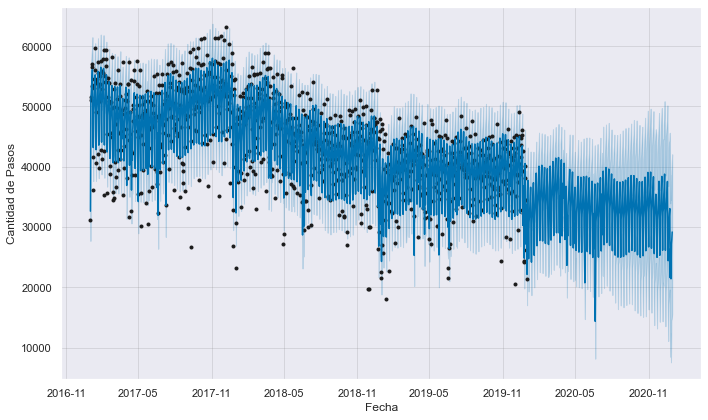

In [78]:
fig1 = prophet_model_final.plot(forecast_model_final,xlabel='Fecha',ylabel='Cantidad de Pasos')

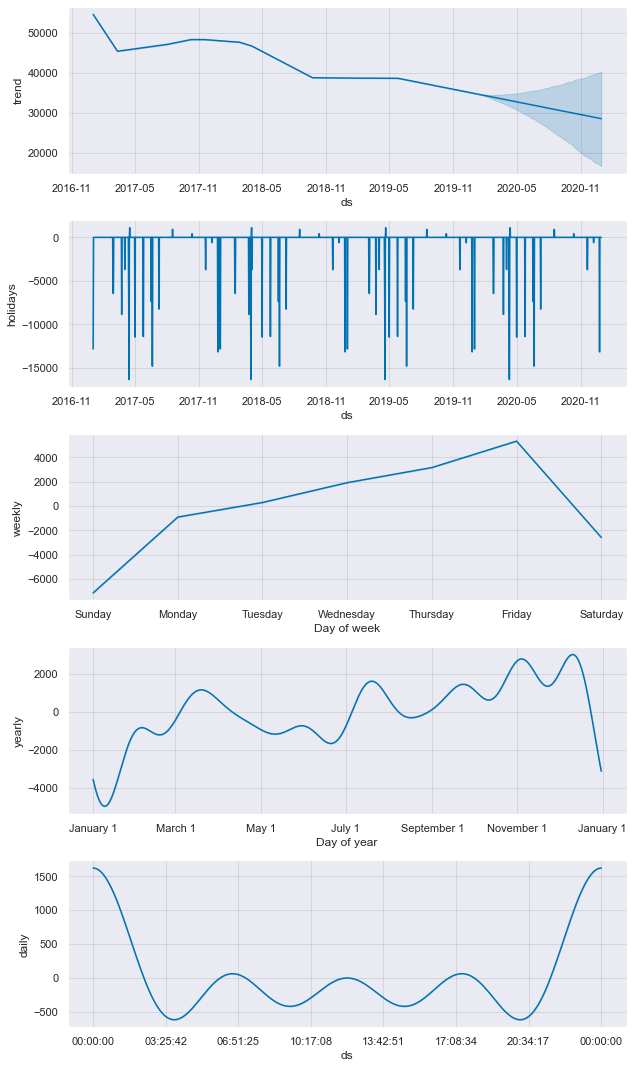

In [79]:
fig_2 = prophet_model_final.plot_components(forecast_model_final)

In [80]:
#forecast_model_final

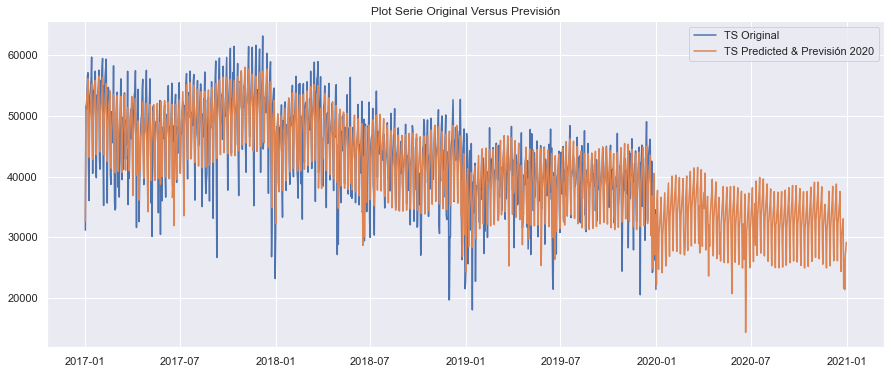

In [81]:
#Plot - Modelo Final y Previsión
plt.figure(figsize = (15,6))
#Plot TS Original
plt.plot(DS_prophet['ds'], DS_prophet['y'])#,label='y_real')
#Plot Forecast
plt.plot(forecast_model_final['ds'], forecast_model_final['yhat'])#,label='Y_predicted')

##forecast
##Plot test
#plt.plot(pd.to_datetime(X_test.index), y_test.values)#,label='Y_predicted')
##Plot y test pred
#plt.plot(prevision_model_final['ds'], prevision_model_final['yhat'])#,label='Y_predicted')

plt.title('Plot Serie Original Versus Previsión')
#plt.legend(['y train','y train predicted ','y test','y test predicted'])
plt.legend(['TS Original','TS Predicted & Previsión 2020'])
plt.show()

## **Elección de la métrica:**

   #### De las métricas disponibles <font color='green'>**MAE, MSE, RMSE**</font> y de un análisis previo de que obtengo con cada una de estas, se opto por <font color='green'>**RMSE**</font>, ya que con esta obtenemos el valor promedio real del error (+/-) en la unidad de medida que estamos prediciendo. Este es altamente sensible a <font color='red'>**outliers**</font>, pero como nos encargamos de quitar dichos valores previo a realizar la predicción, esto no es un problema que nos preocupe.

## **Modelos para la previsión:**
   #### Se eligió como Modelo Benchmark un modelo de ensamble del aprendizaje supervisado como es RFR (Random Forest Regressor), del cual se obtuvo una puntuación RMSE elevada, pero el valor obtenido no es para nada despreciable ya que este fue de mejor puntuación que el modelo inicial de Prophet, pero se puede apreciar en base  a la puntuación obtenida en Train que el modelo pareciera caer en Overfitting.
   
   #### Me vi "tentado" a usar una regresión lineal, ya que entrené un modelo y este obtuvo una puntuación mayor que el modelo final de prophet, pero en pos de realizar un trabajo a conciencia y teniendo más herramientas en el modelo RFR, como es por ejemplo, el método feature_importances_ , dejé finalmente como Modelo Benchmark RFR.
   
   #### Para continuar con la previsión final se optó por un modelo específico de series de tiempo como es la librería Prophet de Facebook, la cual se entrenó en una primera instancia con sus hiperparámetros por default. Para luego proceder a realizar el tuning de sus hiperparámetros utilizando **ParameterGrid** de la librería sklearn, con esto se logró una mejora en el valor RMSE, pero aún así no fue posible mejorar la performance obtenida por RFR, pero en base a la sospecha de que el modelo de RFR cae en Overfitting se opta por el modelo Prophet, el cual presenta una puntuación estable tanto en Train como en Test.
   #### A continuación se detalla en resumen la puntuación RMSE obtenida en los modelos:

* #### Valor RMSE Modelo Benchmark RFR:
#### <font color='green'>Raíz del error cuadrático medio en Train: 1869.84</font>
#### <font color='green'>Raíz del error cuadrático medio en Test: 5416.7</font>

* #### Valor RMSE Modelo Prophet inicial:
#### <font color='green'>Raíz del error cuadrático medio en Train: 4693.65</font>
#### <font color='green'>Raíz del error cuadrático medio en Test: 6050.57</font>

* #### Valor RMSE Modelo Prophet Final con optimización de hiperparámetros:
#### <font color='green'>Raíz del error cuadrático medio en Test: 5567.88</font>

### Parte 3 - Mejoras extras en el modelo final:

#### Para la mejora del modelo investigué sobre el agregado de features, esto es posible en Prophet utilizando el método **add_regressor()**.

In [82]:
DS_prophet = pd.DataFrame()

DS_prophet["ds"] = pd.to_datetime(diario.index)
DS_prophet["y"] = diario['cantidad_pasos'].values
DS_prophet['day_of_week'] = DS_prophet["ds"].dt.dayofweek

In [83]:
#DS_prophet

In [84]:
end_date = '2019-09-30'
mask1 = (DS_prophet['ds'] <= end_date)
mask2 = (DS_prophet['ds'] > end_date)

In [85]:
X_train = DS_prophet.loc[mask1]
X_test = DS_prophet.loc[mask2]
print("train shape",X_train.shape)
print("test shape",X_test.shape)

train shape (1003, 3)
test shape (92, 3)


In [86]:
params_grid = {'seasonality_mode':['additive'],
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
               'seasonality_prior_scale': [0.1,0.2,0.3,0.4,0.5],
               'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5]
              }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 125


In [87]:
strt='2019-10-01'
end='2019-12-31'

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])

for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(seasonality_mode = p['seasonality_mode'],
                         changepoint_prior_scale = p['changepoint_prior_scale'],
                         seasonality_prior_scale = p['seasonality_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True)
    train_model.add_country_holidays(country_name='AR')
    train_model.add_regressor('day_of_week')
    train_model.fit(X_train)
    train_forecast = train_model.make_future_dataframe(periods=92, freq='D',include_history = False)
    train_forecast['day_of_week'] = X_train['day_of_week']
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = DS_prophet[(DS_prophet['ds']>=strt) & (DS_prophet['ds']<=end)]
    #EL puntaje RMSE se calcula en X_test
    RMSE = round(np.sqrt(mean_squared_error(Actual['y'],abs(test['yhat']))),2)
    print('(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}
(RMSE)------------------------------------ 6158.05
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.2}
(RMSE)------------------------------------ 6158.75
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3}
(RMSE)------------------------------------ 6148.36
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.4}
(RMSE)------------------------------------ 6188.9
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
(RMSE)------------------------------------ 6155.26
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'seasonality_mode': 'additive', 'seasonality_prior_sca

In [88]:
#Ordeno los resultados para obtener posteriormente el menor valor de RMSE
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters
0,5592.04,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
1,5616.71,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
2,5619.33,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
3,5636.12,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
4,5647.93,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [89]:
print('Best params:')
parameters['Parameters'][0]

Best params:


{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 0.1,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 0.4}

### En este caso en particular podemos observar que el agregado de un regresor, el cual fue el día de la semana en valor númerico, no mejoró el modelo obtenido anteriormente. Razón por la cual se desestima el agregado de dicho regresor y se deja como modelo final el optimizado antes a la realización del punto 3.

## Conclusión final:

### El proyecto fue realmente un gran desafío, tuve que investigar mucho para poder llegar a los resultados que se exponen a lo largo del notebook, igualmente disfruté la realización del mismo. También me surgió a medida que culminaba y ya pensando en el proyecto 4, si este notebook que hoy entrego, satisface las condiciones de entrega de este último proyecto ya que su enunciado principal se basa en esta premisa: <font color='green'>Agregar al menos una fuente de datos para complementar/enriquecer el dataset original o prueben un modelo que hasta el momento no hayan aplicado</font>. Al usar Prophet, librería que solo se menciona en las bitácoras de series de tiempo, me motiva a pensar lo antes expuesto.

### Por recomendaciones de mi mentor, las cuales me parecieron acertadas, ya que en un principio estaba obstinado en usar modelos del aprendizaje supervisado que vimos en clases anteriores, ya sean modelos básicos o de ensamble, podría haber caído en lo "fácil" y además de usar como lo hago en mi modelo Benchmark RFR, explayarme en la optimización de hiperparámetros de estos modelos, pero realmente no le encontraba sentido ya que esto fue evaluado en el Proyecto 2.

### Es por esto que pido la mayor neutralidad y objetividad posible de quien evalue el proyecto para dilucidar si estoy realizando ambos proyectos 3 y 4 en este notebook. 

## Próximos pasos

## Interrogantes:

* ### Mejoraría la previsión del modelo de Prophet aplicando más funcionalidades disponibles en la librería?.
   ### Planteado esto, desearía a futuro intentar mejorar la previsión del modelo, graficando, analizando e incluyendo de manera manual Trend Changepoints en el modelo.

 ### Fuente:
 ### https://facebook.github.io/prophet/docs/trend_changepoints.html
 ### https://github.com/facebook/prophet/issues/697
 ### https://pythondata.com/forecasting-time-series-data-prophet-trend-changepoints/#:~:text=these%20changepoints%20with%20.-,changepoints%20.,Prophet(n_changepoints%3D30)%20.

### 
* ### Mejoraría aún más la previsión utilizando modelos de Deep Learning como por ejemplo redes neuronales?.
   ### Por otra parte, y en pos de la mejora en la previsión de series de tiempo otras librerías/modelos que deseo implementar son LSTM con Keras. LSTM, cuyas siglas significan Long Short-Term Memory network, que traducido sería algo así como Red de memoria a corto plazo, tienen un muy buen desempeño en previsión de Series de tiempo, este modelo de redes neuronales recurrentes, se lo puede utilizar, tomando N valores pasados (look_back) y al realizar la predicción a futuro tiene en cuenta justamente estos valores pasados para realizar la predicción.

 ### Fuente:
 ### https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
 ### https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
 ### https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba


## Resultados esperados:
### Respecto a los interrogantes que me surgen, en el primer caso espero al menos una mejora leve en la previsión, pero no muy esperanzado ya que en el caso de la inclusión de regresores al modelo esperaba conseguir mejores resultados, lo cual quedó demostrado no fue así en el desarrollo del agregado del feature day_of_week.
### En cuanto a redes neuronales recurrentes LSTM con Keras, espero conseguir una previsión más exacta, ya que estos modelos y en particular LSTM como se expuso es un modelo que demuestra muy buenos resultados en series de tiempo.
